# Emotion Classifier

## Instalación de bibliotecas

In [67]:
#%pip install mediapipe
#%pip install imbalanced-learn
#%pip install opencv-python

## Bibliotecas

In [68]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib

## Rutas de entrada

In [69]:
RUTA_BASE = "SAMMv3"
TAMAÑO_FINAL = 224

MAPEO_EMOCIONES = {
    "Anger": 0,
    "Contempt": 1,
    "Disgust": 2,
    "Fear": 3,
    "Happiness": 4,
    "Sadness": 5,
    "Surprise": 6
}

## Funciones de preprocesamiento de imágenes

### Función `cargar_imagen` realiza lo siguiente:
1. Carga una imagen y la convierte en un arreglo de numpy donde cada pixel se representa como un valor numérico (esto si la imagen está en escala de grises) o como un conjuntos de valores si la imagen es a color.

2. Esta imagen se reduce a la mitad de su tamaño original (1/2 resolución) con la función IMREAD_REDUCED_GRAYSCALE_2.


Resultado: Imagen procesada como un arreglo de 2 dimensiones (alto, ancho).

In [70]:
def cargar_imagen(ruta):
    try:
        # IMREAD_REDUCED_GRAYSCALE_2 carga en escala de grises la imagen reducida a su mitad. 
        # Por ejemplo si se carga una imagen de 500x300 el tamaño final seria de 250x150 px.
        imagen = cv2.imread(ruta, cv2.IMREAD_REDUCED_GRAYSCALE_2)
        if imagen is None:
            return None
        return imagen
    except:
        return None

### Función `recortar_imagen` realiza lo siguiente:
1. Recorta la imagen cargada a un cuadrado y luego la redimensiona al TAMAÑO_FINAL (224x224 px)

Resultado: Imagen en 224x224 px

In [71]:
def recortar_imagen(imagen):
    try:
        alto, ancho = imagen.shape[:2] # obtener el alto y ancho de la imagen
        # se toma el lado mas pequeño para recortar un cuadro centrado en la imagen
        lado = min(alto, ancho)
        y = (alto - lado) // 2
        x = (ancho - lado) // 2
        recorte = imagen[y:y+lado, x:x+lado]
        # se redimensiona la imagen recortada al tamaño final deseado (224x224 px)
        return cv2.resize(recorte, (TAMAÑO_FINAL, TAMAÑO_FINAL))
    except:
        return None

### Función `extraer_landmarks` realiza lo siguiente:
1. Recibe una imagen y una instancia del mallador de MediaPipe (FaceMesh), que se encarga de detectar puntos clave del rostro (landmarks).
2. MediaPipe requiere imágenes a color, por lo que también verifica si la imagen es en escala de grises.

La condición `if resultados.multi_face_landmarks` verifica si se detectó al menos un rostro en la imagen, ya que `multi_face_landmarks` es una lista con los resultados de los landmarks de cada cara encontrada, por lo tanto si no se detecta ningún rostro, se regresa un None, pero si se detecta una cara, entonces se toma con `resultados.multi_face_landmarks[0]` (el hecho de que sea índice 0 indica que es el primer rostro detectado).
Luego se accede a `.landmark`, esto es una lista de 468 puntos faciales del modelo Face Mesh, donde cada punto tiene coordenadas `(x, y, z)`, aunque en este caso solo se tomaron las coordenadas `x` e `y` para construir un arreglo de numpy de la forma `(468, 2)`, donde el 468 indica que son 468 puntos faciales y el 2, su número de coordenadas por cada punto. De manera que el arreglo tendría la siguiente forma: [[coordenada x1, coordenada y1],[coordenada x2, coordenada y2], ...]

Resultado: Un arreglo de numpy con las coordenadas normalizadas (x, y) de los puntos clave del rostro o None, si no se detectó ninguna cara.

In [72]:
def extraer_landmarks(imagen, mallador):
    try:
        if len(imagen.shape) == 2: # verificar si la imagen es en escala de grises. Si lo es, entonces se convierte a RGB
            imagen = cv2.cvtColor(imagen, cv2.COLOR_GRAY2RGB) 
        # procesar la imagen con el mallador de MediaPipe
        resultados = mallador.process(imagen)
        ########################################################################################
        if resultados.multi_face_landmarks: 
            return np.array([[p.x, p.y] for p in resultados.multi_face_landmarks[0].landmark])
        ########################################################################################
    except:
        return None
    return None

### Función `normalizar_landmarks`
El objetivo de este paso es transformar los landmarks para que no se vean afectados por el tamaño del rostro y de su posición en la imagen, por lo tanto lo que recibe esta función es un arreglo de landmarks que tiene la forma (468, 2) y donde cada fila es un punto del rostro con coordenadas normalizadas (x, y) entre 0 y 1 (este arreglo fue la salida de MediaPipe que se proceso con la función `extraer_landmarks`).

Por lo tanto, el resultado de aplicar esta función es un vector centrado y escalado de 936 valores que representa la forma del rostro sin importar su posición o tamaño en la imagen que se procese.

In [73]:
def normalizar_landmarks(landmarks):
    try:
        centro = landmarks[1] # landmarks[1] es un punto fijo del rostro por ejemplo la nariz
        landmarks -= centro # se resta el "centro" a los demás puntos de landmarks para centrar la cara
        escala = np.linalg.norm(landmarks[234] - landmarks[454]) # calcula la distancia entre dos puntos fijos del rostro, en este caso, el landmark 234 
        # es la mejilla izquierda y el 454 es la mejilla derecha, esto para obtener el ancho de la cara
        return (landmarks / escala).flatten() # .fltten convierte el arreglo de forma (468, 2) a un arreglo de una dimensión (936,), es decir, un vector de 936 valores
    except:
        return None

## Carga de datos y balanceo de datos

### Función `cargar_dataset`:
-Se carga el modelo de detección landmarks  con: **mp.solutions.face_mesh** 

-Se crea el objeto **mallador**, el cual se utilizará para procesar las imágenes y extraer sus landmarks.

-Se inicializa un diccionario **datos_por_clase** que almacenará los datos obtenidos por cada emoción.

-Luego con **MAPEO_EMOCIONES**, se accede a la carpeta correspondiente con las imágenes por cada emoción.

-Se verifica que la carpeta exista y que contenga imágenes en formato .jpg


* Si hay más de 900 imágenes, solo se usan solo 900 para mantener un balance entre las clases y luego dentro del bucle **for archivo in tqdm ...** se utilizan las funciones previamente desarrolladas para cargar y procesar cada imagen.

* En otro caso, donde haya menos de 800 imágenes, se aplica SMOTE (Synthetic Minority Oversampling Technique) para generar muestras sintéticas hasta llegar a 800 muestras.


In [74]:
def cargar_dataset():
    mp_face_mesh = mp.solutions.face_mesh
    mallador = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3)
    # PARAMETROS:
        # static_image_mode=True: indica que se procesarán imágenes, no un video.
        # max_num_faces=1: es el núm. máximo de rostros que buscará el modelo por cada imagen.
        # min_detection_confidence=0.3: solo se detectarán landmarks si el modelo tiene al menos 30% de confianza en que hay un rostro en la imagen.

    datos_por_clase = {}

    for emocion, codigo in MAPEO_EMOCIONES.items():
        carpeta = os.path.join(RUTA_BASE, emocion)
        if not os.path.exists(carpeta):
            print(f"Carpeta no encontrada. {carpeta}")
            continue

        archivos = [f for f in os.listdir(carpeta) if f.lower().endswith('jpg')]
        total = len(archivos)
        if total == 0:
            continue
        # si hay más de 900 imágenes, solo se usan solo 900 para mantener un balance entre las clases.
        if total > 900:
            archivos = archivos[:900]

        print(f"Procesando '{emocion}' ({len(archivos)} imágenes)...")
        # Se inicializan las listas X_tmp, y_tmp para almacenar los landmarks normalizados y las etiquetas de cada emocion
        X_tmp, y_tmp = [], []

        for archivo in tqdm(archivos, desc=f"Procesando {emocion}"):
            ruta = os.path.join(carpeta, archivo)
            img = cargar_imagen(ruta)
            if img is not None:
                img_proc = recortar_imagen(img)
                if img_proc is not None:
                    landmarks = extraer_landmarks(img_proc, mallador)
                    if landmarks is not None:
                        norm = normalizar_landmarks(landmarks)
                        if norm is not None:
                            X_tmp.append(norm)
                            y_tmp.append(codigo)

        if len(X_tmp) < 800 and len(X_tmp) > 0:
            print(f"Aplicando SMOTE para '{emocion}' ({len(X_tmp)} -> 800)...")
            X_tmp.append(np.zeros_like(X_tmp[0])) 
            y_tmp.append(-1) 
            smote = SMOTE(sampling_strategy={codigo: 800}, random_state=42) # se aplica SMOTE para balancear la clase
            X_res, y_res = smote.fit_resample(X_tmp, y_tmp)
            X_tmp = [x for x, yv in zip(X_res, y_res) if yv == codigo]
            y_tmp = [codigo] * len(X_tmp)

        datos_por_clase[codigo] = (X_tmp, y_tmp) # vector landmarks norms., etiqueta por cada emocion

    mallador.close() # liberar recursos del objeto FaceMesh
    X, y = [], []
    for Xc, yc in datos_por_clase.values():
        X.extend(Xc)
        y.extend(yc)

    return np.array(X), np.array(y)

## Entrenar y evaluar el modelo

En este bloque de código se hace lo siguiente: 

-Define un pipeline en el cual se usa **StandardScaler()** para estandarizar los vectores de entrada (restar la media y dividir por la desviación estándar), esto se hace porque el modelo SVM es sensible a la escala de los datos.

-Luego se aplica un clasificador SVM (Máquinas de Vectores de Soporte) con kernel RBF (Radial Basis Function).

-Se configuran los siguientes hiperparámetros:

        C=1: penalización por errores (más grande = más ajuste al entrenamiento (overfitting)).

        gamma='scale': controla la influencia de cada muestra, scale es el valor recomendado por defecto.

        class_weight='balanced': ajusta automáticamente el peso de cada clase con base en su frecuencia.

Finalmente se entrena el modelo con los datos de X_train, y_train para obtener el modelo que realice las clasificaciones y guardarlo en un pkl con **joblib.dump**.

In [75]:
print("****CARGANDO DATASET****")
X, y = cargar_dataset()
print(f"\nTotal de muestras: {len(X)}\nDistribución final:", Counter(y)) # verificar el balance entre emociones

print("\n****VALIDACIÓN CRUZADA****")
modelo = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'))
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(modelo, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(modelo, X, y, cv=cv, scoring='f1_macro')
print(f"Accuracy promedio: {acc_scores.mean():.4f}")
print(f"F1 macro promedio: {f1_scores.mean():.4f}")

print("\n****ENTRENAMIENTO FINAL****")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)
modelo.fit(X_train, y_train)

print("\n****GUARDANDO MODELO****")
joblib.dump(modelo, "modelo_emociones.pkl")

print("\n****EVALUACIÓN****")
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=MAPEO_EMOCIONES.keys()))

****CARGANDO DATASET****
Procesando 'Anger' (900 imágenes)...


Procesando Anger: 100%|██████████| 900/900 [00:08<00:00, 106.92it/s]


Procesando 'Contempt' (896 imágenes)...


Procesando Contempt: 100%|██████████| 896/896 [00:08<00:00, 105.46it/s]


Procesando 'Disgust' (666 imágenes)...


Procesando Disgust: 100%|██████████| 666/666 [00:06<00:00, 104.77it/s]


Aplicando SMOTE para 'Disgust' (666 -> 800)...
Procesando 'Fear' (534 imágenes)...


Procesando Fear: 100%|██████████| 534/534 [00:05<00:00, 105.90it/s]


Aplicando SMOTE para 'Fear' (534 -> 800)...
Procesando 'Happiness' (900 imágenes)...


Procesando Happiness: 100%|██████████| 900/900 [00:08<00:00, 104.62it/s]


Procesando 'Sadness' (391 imágenes)...


Procesando Sadness: 100%|██████████| 391/391 [00:03<00:00, 105.00it/s]


Aplicando SMOTE para 'Sadness' (391 -> 800)...
Procesando 'Surprise' (900 imágenes)...


Procesando Surprise: 100%|██████████| 900/900 [00:08<00:00, 104.35it/s]



Total de muestras: 5996
Distribución final: Counter({np.int64(0): 900, np.int64(4): 900, np.int64(6): 900, np.int64(1): 896, np.int64(2): 800, np.int64(3): 800, np.int64(5): 800})

****VALIDACIÓN CRUZADA****
Accuracy promedio: 0.9453
F1 macro promedio: 0.9449

****ENTRENAMIENTO FINAL****

****GUARDANDO MODELO****

****EVALUACIÓN****
              precision    recall  f1-score   support

       Anger       0.90      1.00      0.95       180
    Contempt       0.99      0.93      0.96       180
     Disgust       0.96      1.00      0.98       160
        Fear       1.00      1.00      1.00       160
   Happiness       0.95      0.97      0.96       180
     Sadness       0.84      1.00      0.91       160
    Surprise       1.00      0.73      0.84       180

    accuracy                           0.94      1200
   macro avg       0.95      0.95      0.94      1200
weighted avg       0.95      0.94      0.94      1200



## Visualización

### Función `predecir_emocion`:
-Se carga el modelo previamente entrenado con **joblib.load("modelo_emociones.pkl")**.

-Se genera un diccionario **MAPEO_EMOCIONES_INV**, que invierte las claves y valores de **MAPEO_EMOCIONES** para poder traducir el resultado numérico de la predicción en texto.

* Dentro de la función:

-Se carga la imagen original sin ningún proceso, esta imagen se usa únicamente para mostrarla junto con la predicción.

-Luego, se carga por segunda vez la imagen usando la función **cargar_imagen()** para procesarla.

-Se recorta la imagen usando **recortar_imagen()** para convertirla en un cuadrado.

-Se extraen los landmarks faciales con **extraer_landmarks()**.

* Si la extracción fue exitosa, los landmarks se copian para su visualización, y luego se normalizan con **normalizar_landmarks()** para generar el vector que será usado por el modelo.

-Se realiza la predicción con **modelo.predict([norm_landmarks])**, y se obtiene la etiqueta de la emoción correspondiente a través de **MAPEO_EMOCIONES_INV**.

-Por último, se muestra la predicción con su imagen sin procesar.

In [76]:
modelo = joblib.load("modelo_emociones.pkl") # carga de modelo previamente entrenado
MAPEO_EMOCIONES_INV = {v: k for k, v in MAPEO_EMOCIONES.items()}
mp_face_mesh = mp.solutions.face_mesh
mallador = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3)


def predecir_emocion(ruta_imagen):
    # cargar imagen original sin procesar, es decir, tal cual como se subió 
    img_original = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if img_original is None:
        print("No se pudo cargar la imagen original.")
        return

    # cargar la versión reducida para procesamiento
    img = cargar_imagen(ruta_imagen)  # esta sí puede ser reducida y en gris
    if img is None:
        print("No se pudo cargar la imagen para análisis.")
        return

    img_proc = recortar_imagen(img)
    if img_proc is None:
        print("No se pudo procesar la imagen.")
        return

    landmarks = extraer_landmarks(img_proc,mallador)
    if landmarks is None:
        print("No se detectaron landmarks.")
        return

    landmarks_visuales = landmarks.copy()
    norm_landmarks = normalizar_landmarks(landmarks)
    if norm_landmarks is None:
        print("No se pudo normalizar la imagen.")
        return

    pred = modelo.predict([norm_landmarks])[0]
    emocion = MAPEO_EMOCIONES_INV[pred]

    # imagen con landmarks
    img_color = cv2.cvtColor(img_proc.copy(), cv2.COLOR_GRAY2BGR)
    h, w = img_proc.shape[:2]

    for punto in landmarks_visuales:
        x = int(punto[0] * w)
        y = int(punto[1] * h)
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(img_color, (x, y), 2, (0, 255, 0), -1)

    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_con_landmarks = cv2.cvtColor(img_color.copy(), cv2.COLOR_BGR2RGB)

    # mostrar la imagen sin procesar y la imagen con landmarks
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original_rgb)
    plt.title("Original (sin procesar)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_con_landmarks)
    plt.title(f"Predicción: {emocion}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

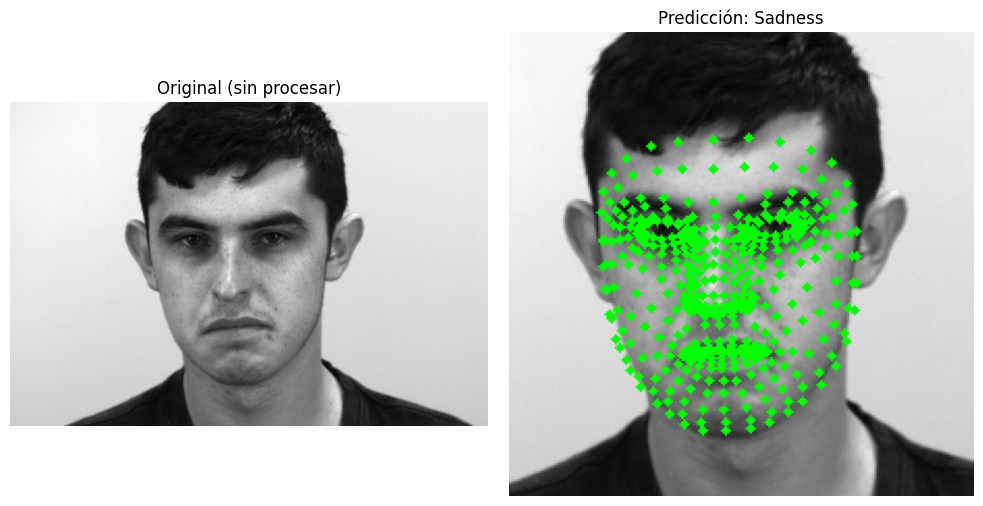

In [77]:
# pruebas
predecir_emocion("pruebas/p1.jpg")

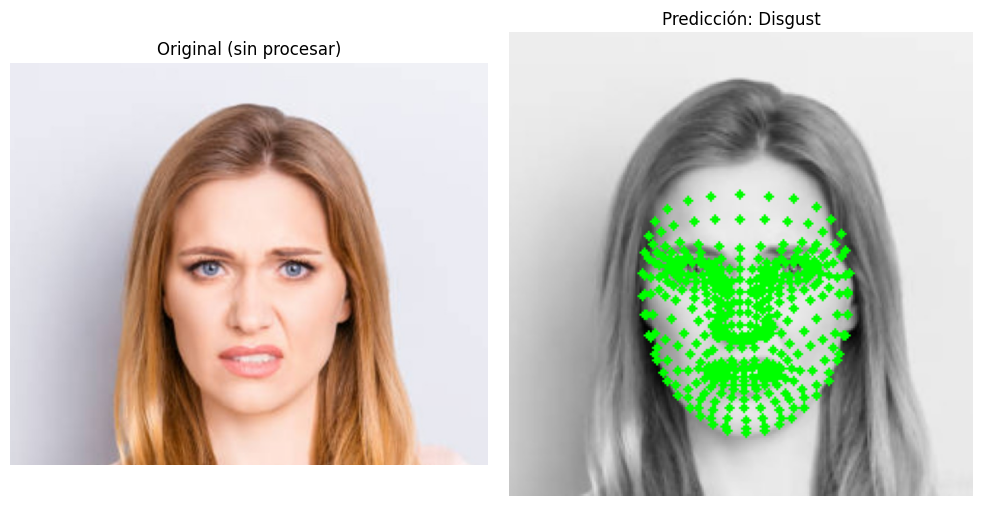

In [78]:
predecir_emocion("pruebas/p2.jpg")

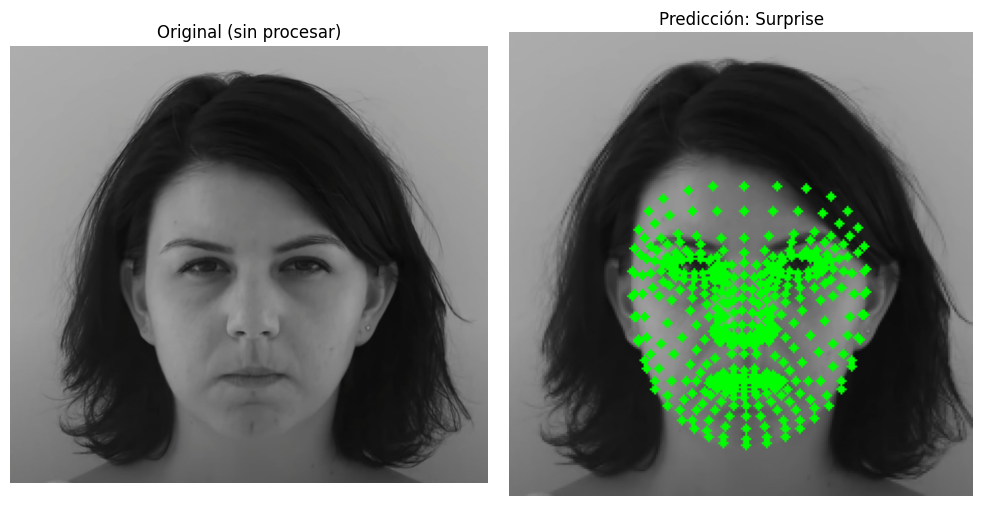

In [ ]:
predecir_emocion("pruebas/p3.jpg") 

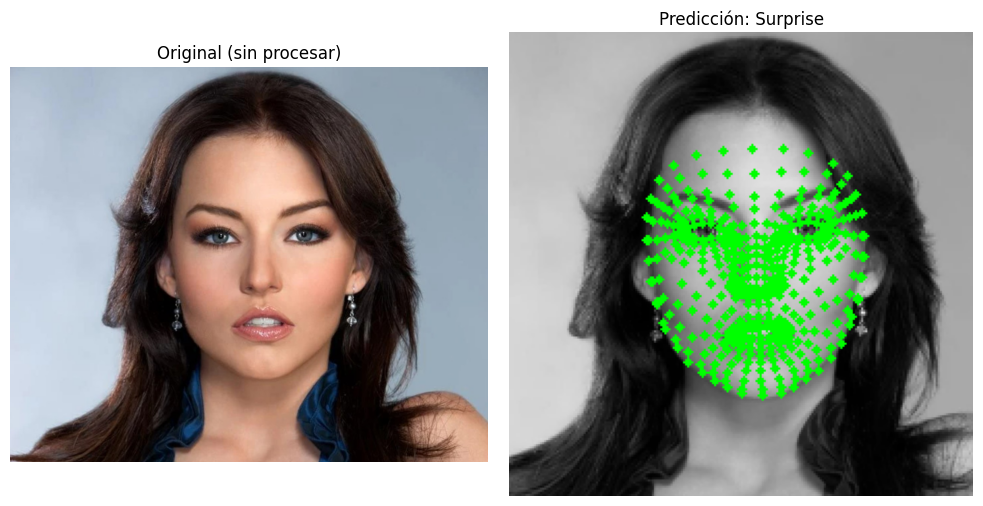

In [ ]:
predecir_emocion("pruebas/p4.jpg") 

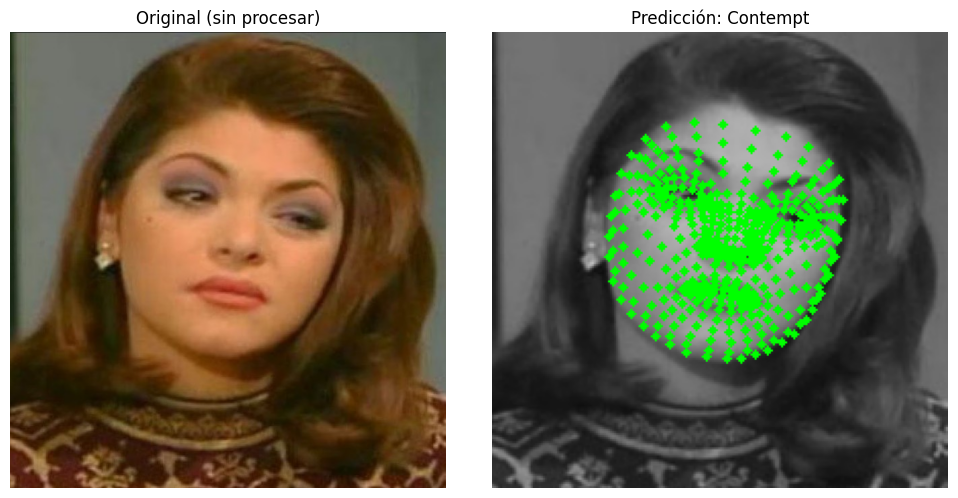

In [ ]:
predecir_emocion("pruebas/p5.jpg") 